In [1]:
MODEL_PATH = 'architectures/'
DATASET_PATH = 'dataset/'

RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.

# Importing the necessary packages

In [2]:
# If you are running on `Binder`, then it is no need to set up the packages again
# %pip install -r requirements.txt

# ---OR---

# %pip install tensorflow==2.10.1 numpy==1.26.4 pandas scikit-learn imblearn matplotlib seaborn requests

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import utils

np.random.seed(RANDOM_SEED)

Python Version: `3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


# Getting Relevant Data

### Download dataset

In [4]:
utils.download_dataset_from_kaggle('fraudTrain.csv')

URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTrain.csv


Extracted archive... | Succeeded


### Read data

In [5]:
data = pd.read_csv(os.path.join(DATASET_PATH, 'fraudTrain.csv'), index_col=0)

# Credit Card Fraud Dataset Fields

| Field # | Field Name | Description |
|---------|------------|-------------|
| 1 | **trans_date_trans_time** | Date and time when transaction occurred |
| 2 | **cc_num** | Credit card number of customer |
| 3 | **merchant** | Name of merchant where transaction occurred |
| 4 | **category** | Category of merchant (e.g., retail, food, etc.) |
| 5 | **amt** | Amount of transaction |
| 6 | **first** | First name of credit card holder |
| 7 | **last** | Last name of credit card holder |
| 8 | **gender** | Gender of credit card holder |
| 9 | **street** | Street address of credit card holder |
| 10 | **city** | City of credit card holder |
| 11 | **state** | State of credit card holder |
| 12 | **zip** | ZIP code of credit card holder |
| 13 | **lat** | Latitude location of credit card holder |
| 14 | **long** | Longitude location of credit card holder |
| 15 | **city_pop** | Population of credit card holder's city |
| 16 | **job** | Occupation of credit card holder |
| 17 | **dob** | Date of birth of credit card holder |
| 18 | **trans_num** | Transaction number |
| 19 | **unix_time** | UNIX timestamp of transaction |
| 20 | **merch_lat** | Latitude location of merchant |
| 21 | **merch_long** | Longitude location of merchant |
| 22 | **is_fraud** | Target class indicating whether transaction is fraudulent (1) or legitimate (0) |

# Feature Engineering

In [6]:
data['is_fraud'].value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [7]:
data.isnull().any().sum()

0

no mising data

In [8]:
data = utils.feature_engineering(data)

# Analysis

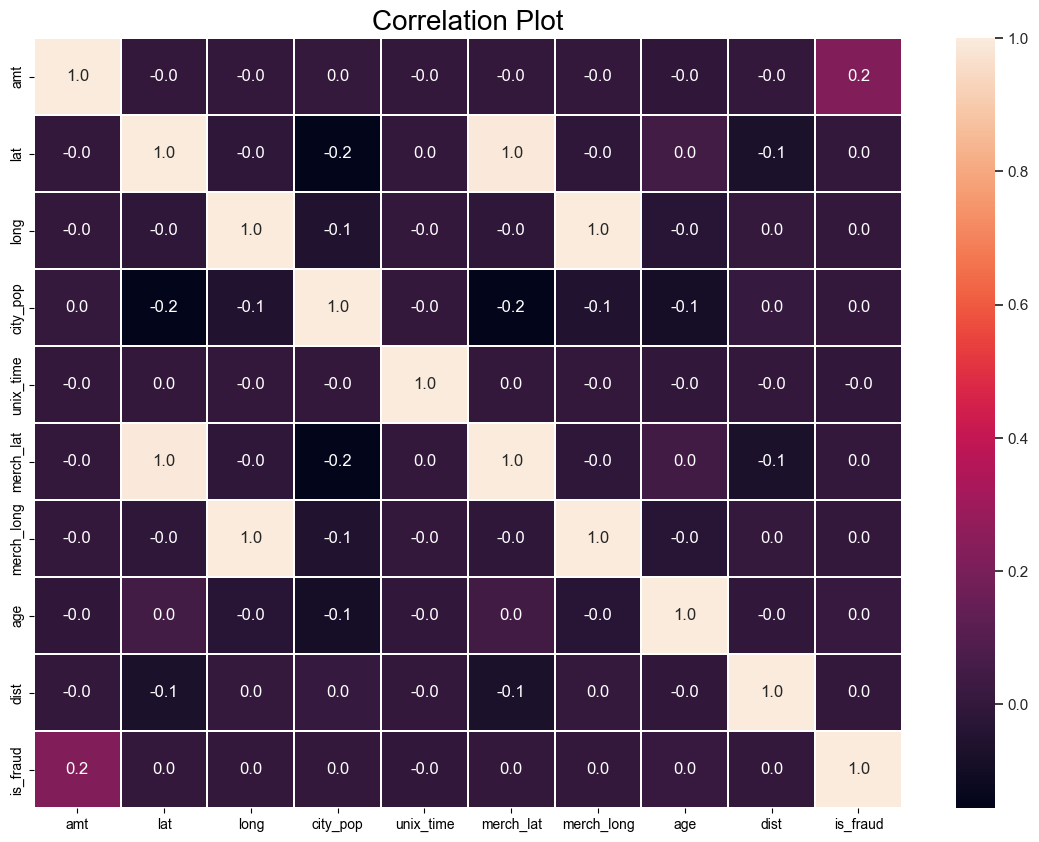

In [9]:
float_types_columns = []
for col in data:
    try:
        data[col].astype('float')
        float_types_columns.append(col)
    except:
        continue

plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data[float_types_columns].corr()
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,fmt='.1f',annot=True)
plt.show()

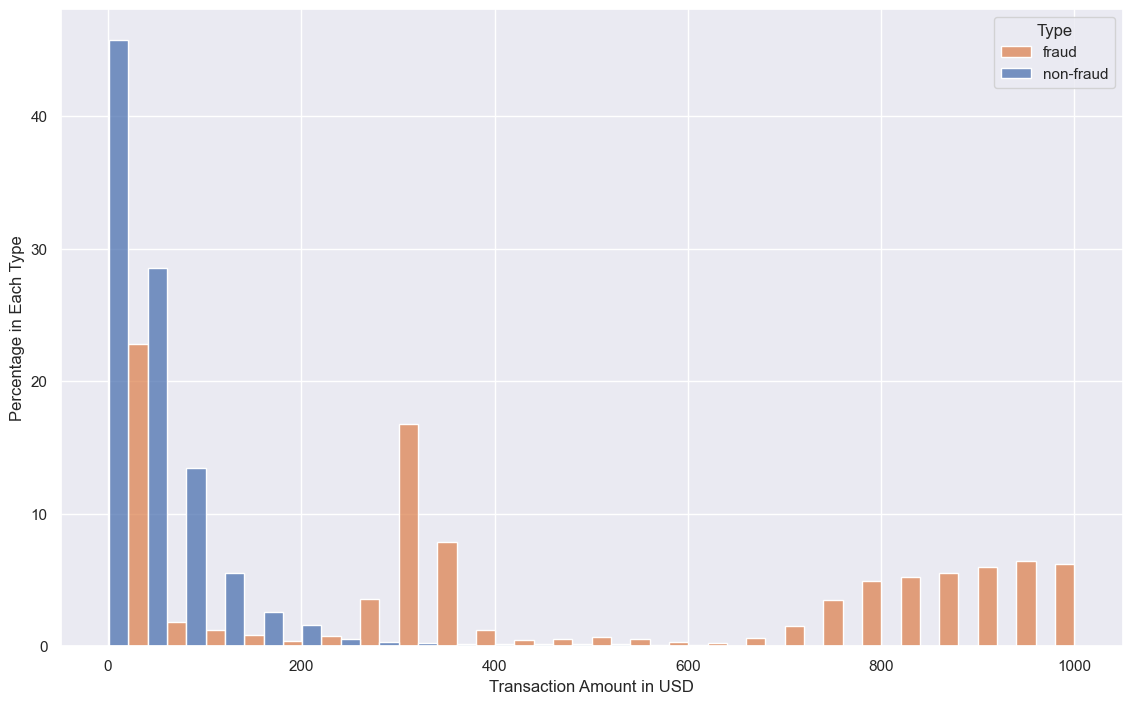

In [29]:
df = data
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['fraud', 'non-fraud'])

In [11]:
# Get all the fraud data
fraud_data = data[data['is_fraud'] == 1]

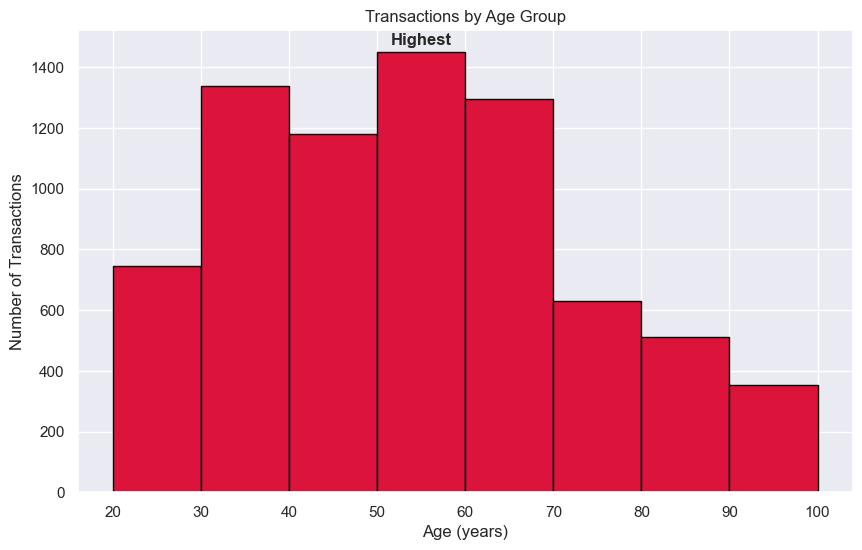

The age group with the most fraud transactions is 50 to 60 with 1450 fraud transactions.


In [35]:
# Define age bins (from 18 to 90 in 10-year increments)
age_bins = range(data['age'].min(), data['age'].max()+10, 10)

plt.figure(figsize=(10, 6))
plt.xlabel('Age (years)')
plt.ylabel('Number of Transactions')
plt.title('Transactions by Age Group')
plt.xticks(age_bins)

# Create the histogram
counts, bins, patches = plt.hist(fraud_data['age'], bins=age_bins, edgecolor='black', color='crimson')

# Annotate the age group with highest transactions
plt.annotate(f'Highest', 
             xy=(bins[counts.argmax()] + 5, counts.max()),
             xytext=(0, 5),
             textcoords='offset points',
             ha='center',
             fontweight='bold',
)

plt.show()

print(f"The age group with the most fraud transactions is {age_bins[counts.argmax()]} to {age_bins[counts.argmax()+1]} with {int(counts.max())} fraud transactions.")

<Axes: xlabel='gender', ylabel='count'>

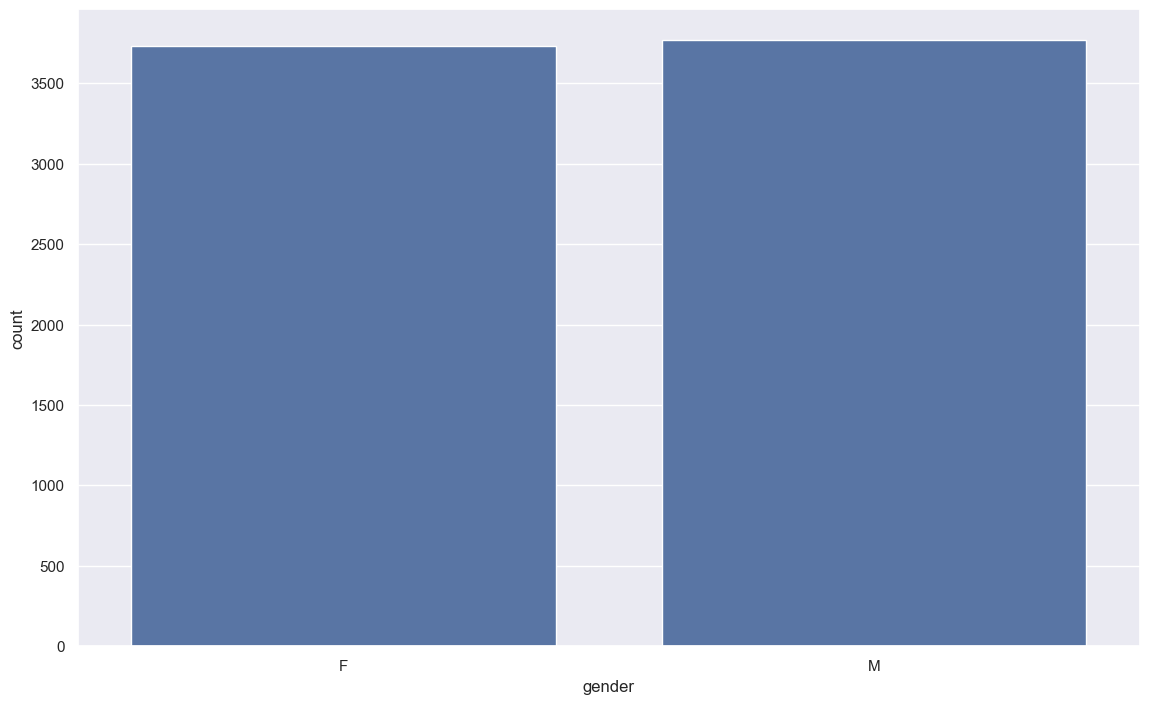

In [13]:
sns.countplot(x="gender", data=fraud_data)

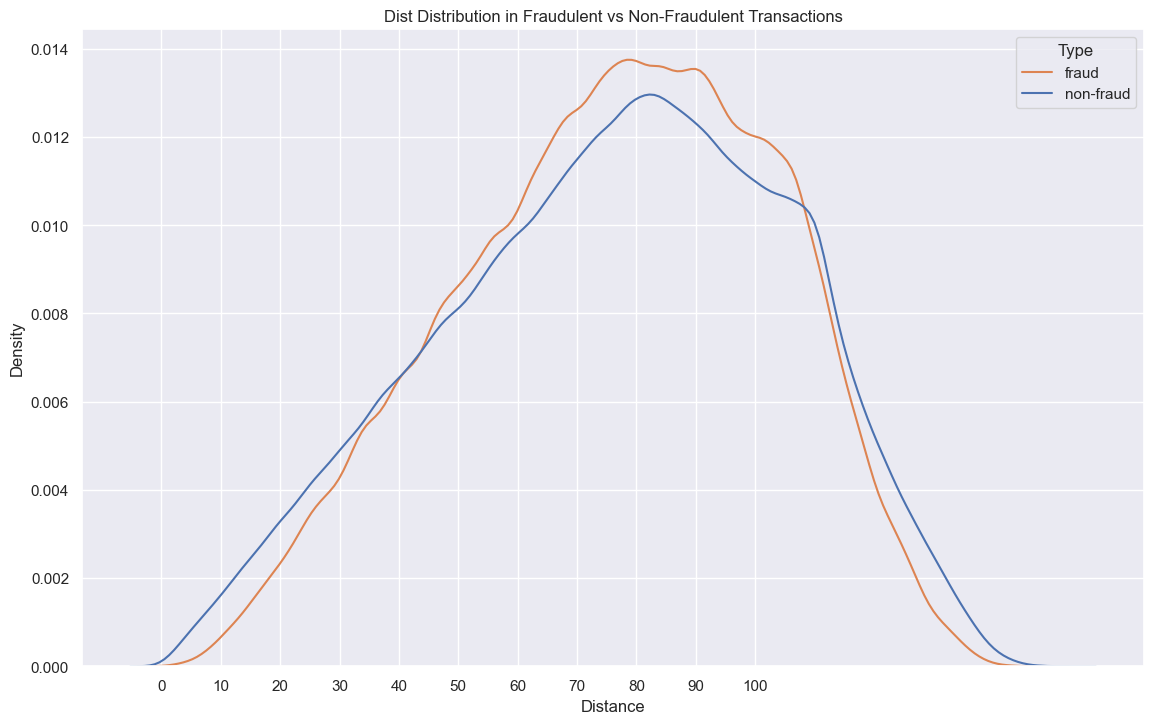

In [30]:
#Relation between distance vs fraud
import datetime as dt
import numpy as np
ax=sns.kdeplot(x='dist',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,10))
plt.title('Dist Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['fraud', 'non-fraud'])

In [15]:
# sns.countplot(x="state",data=df[df["is_fraud"]==1])

# Pre-processing

In [16]:
x, y, data, transformations = utils.pre_processing(data)

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group']`
SMOTE is applied


In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [18]:
X_train.shape

(2062670, 13)

# Model Building

In [19]:
epochs = 50
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())

model.add(Conv1D(32, 2, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 12, 64)            192       
                                                                 
 batch_normalization (BatchN  (None, 12, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            4128      
                                                                 
 dropout (Dropout)           (None, 11, 32)            0         
                                                                 
 dense (Dense)               (None, 11, 64)            2112      
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                        

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [22]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1,callbacks = [callback])

Epoch 1/50
64459/64459 [==============================] - 2431s 37ms/step - loss: 0.1390 - accuracy: 0.9472 - val_loss: 0.0876 - val_accuracy: 0.9695
Epoch 2/50
64459/64459 [==============================] - 1313s 20ms/step - loss: 0.0966 - accuracy: 0.9645 - val_loss: 0.0643 - val_accuracy: 0.9777
Epoch 3/50
64459/64459 [==============================] - 1012s 16ms/step - loss: 0.0855 - accuracy: 0.9690 - val_loss: 0.0539 - val_accuracy: 0.9818
Epoch 4/50
64459/64459 [==============================] - 1008s 16ms/step - loss: 0.0795 - accuracy: 0.9715 - val_loss: 0.0532 - val_accuracy: 0.9830
Epoch 5/50
64459/64459 [==============================] - 1066s 17ms/step - loss: 0.0759 - accuracy: 0.9730 - val_loss: 0.0484 - val_accuracy: 0.9837
Epoch 6/50
64459/64459 [==============================] - 2802s 43ms/step - loss: 0.0725 - accuracy: 0.9745 - val_loss: 0.0435 - val_accuracy: 0.9859
Epoch 7/50
64459/64459 [==============================] - 3203s 50ms/step - loss: 0.0709 - accuracy:

In [23]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

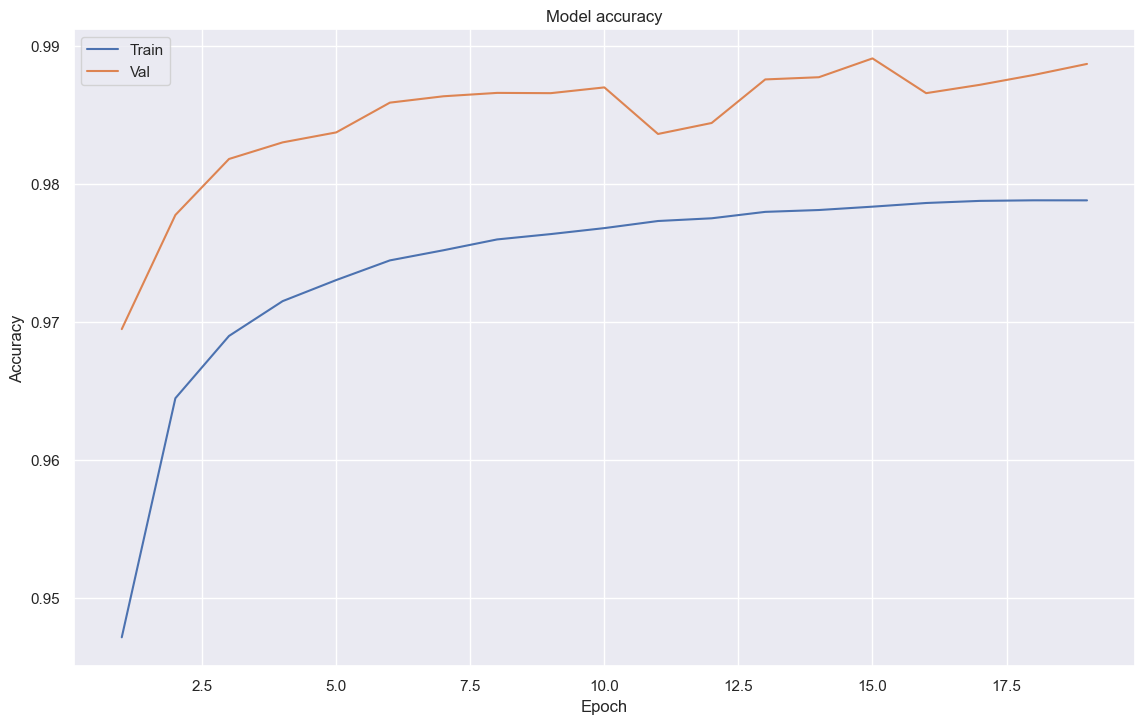

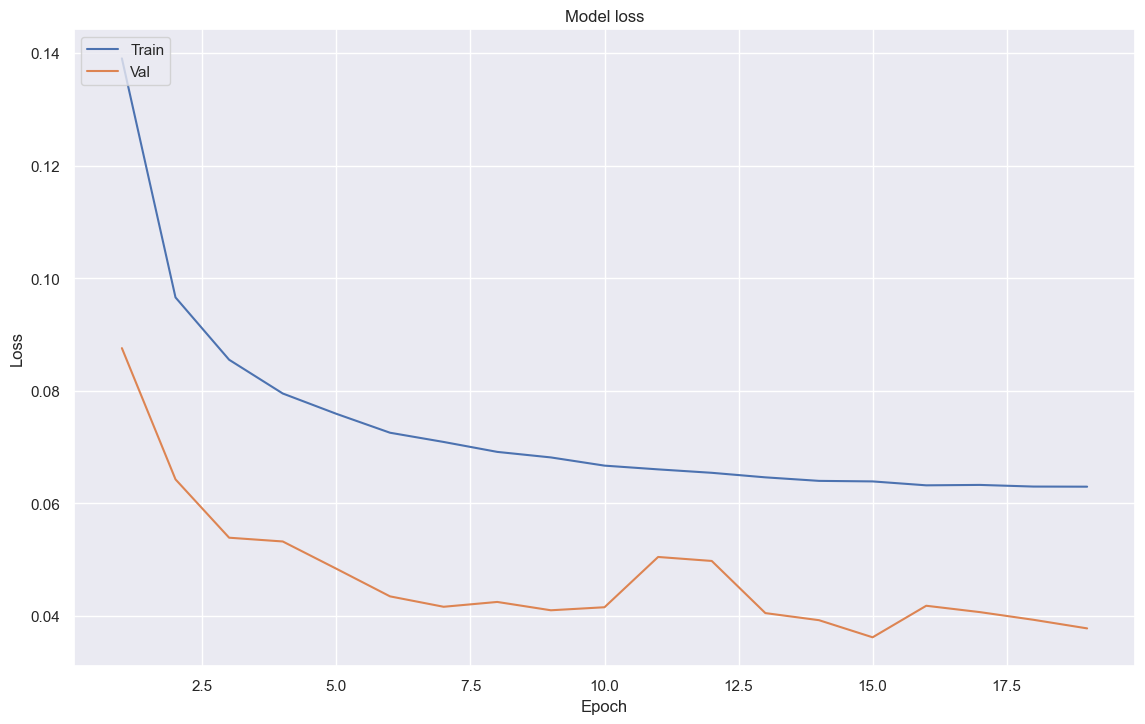

In [24]:
plot_learningCurve(history,len(history.epoch))

In [25]:
y_predict = model.predict(X_test)
y_predict_binary = np.round(y_predict).astype(int).squeeze()

16115/16115 [==============================] - 280s 17ms/step


In [26]:
classificationReport = classification_report(y_test, y_predict_binary)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    258117
           1       0.99      0.99      0.99    257551

    accuracy                           0.99    515668
   macro avg       0.99      0.99      0.99    515668
weighted avg       0.99      0.99      0.99    515668



In [27]:
confusionMatrix = confusion_matrix(y_test, np.round(y_predict).astype(int))
confusionMatrix

array([[254279,   3838],
       [  1790, 255761]], dtype=int64)

In [28]:
# Save the entire ANN model
model.save(os.path.join(MODEL_PATH, f'model_1_Siddhartha_CNN_acc{accuracy_score(y_test, y_predict_binary)*100:.0f}'))
# model.save(os.path.join(MODEL_PATH, f'model_1_Siddhartha_CNN_acc{accuracy_score(y_test, y_predict_binary)*100:.0f}.h5'))

INFO:tensorflow:Assets written to: architectures/model_1_Siddhartha_CNN_acc99\assets


INFO:tensorflow:Assets written to: architectures/model_1_Siddhartha_CNN_acc99\assets
